# Practica ML - Bootcamp Keepcoding 4 - 2019

**Alumno:** Ignacio Gallegos Sánchez

**Correo:** ignacio.gallegos@gmail.com




## Enunciado

El conjunto de datos escogido [este](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0=&location=16,41.38377,2.15774&basemap=jawg.streets), extraído de Airbnb mediante técnicas de scraping. Dentro de las opciones se recomienda utilizar el extract (“Only the 14780 selected records”), ya que minimiza el tiempo de ejecución y evita problemas de memoria en equipos con menos prestaciones.

Es un problema de regresión: se debe que predecir el precio del airbnb utilizando los datos disponibles. Se valorará:
 - Generación de nuevas características a partir de las existentes
 - Codificación de variables
 - Análisis exploratorio
 - Selección y evaluación del modelo
 - Comparativa de distintos algoritmos

## Solución

Lo primero que haremos será abrir el dataset descargado en formato **CSV**

In [1]:
# Imports generales
import numpy as np
import os

# Alguna configuración auxiliar
## Para gráficos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
## Ignoramos Warnings de SciPY (SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Constantes
PROJECT_DIR     = "./"
AIRBNB_FILENAME = "airbnb-listings.csv"
TRAIN_FILENAME  = "train-airbnb.csv"
TEST_FILENAME   = "test-airbnb.csv"


In [2]:
import pandas as pd

def load_data(data_path=PROJECT_DIR + AIRBNB_FILENAME):
    return pd.read_csv(data_path, sep=';', decimal='.')

In [3]:
airbnb = load_data()

Antes de hacer alguna transformación, o variación de los datos de entrada, es **muy importante** separar los datos para **TRAIN** y **TEST**. 
Los datos de **Train** (entrenamiento) los utilizaremos para realizar análisis exploratorios, ver como tratamos los datos de entrada, e implementar el modelo que mejor se comporte con nuestros datos. Hasta el final, no usaremos los datos de **Test** con los cuales probaremos la eficacia real de nuestro modelo anteriormente implementado con nuevos datos "nunca vistos" por nuestro modelo.

In [4]:
from sklearn.model_selection import train_test_split

def my_split_train_test(full_dataframe, train_filename = PROJECT_DIR + TRAIN_FILENAME, test_filename = PROJECT_DIR + TEST_FILENAME, test_size = 0.2):
    train, test = train_test_split(full_dataframe, test_size=test_size, shuffle=True, random_state=0)
    # Escribimos a disco por si más adelante los quisieramos utilizar
    train.to_csv(train_filename, sep=';', decimal='.', index=False)
    test.to_csv(test_filename, sep=';', decimal='.', index=False)
    # Retornamos el resultado
    return train,test

Vamos a quitar directamente los elementos que tengan valores missing en columna tarjet (Precio) ya que no valdrán ni para **train** (no son usables para el algoritmo) ni para **test** no tenemos valores con los que comprobar:

In [5]:
airbnb.dropna(how='any', subset=['Price'], inplace=True)

Ejecutamos la división del DataFrame finalmente en train y test:

In [6]:
airbnb_train, airbnb_test = my_split_train_test(airbnb)

Vemos la información del DataFrame, qué columnas contiene y un ejemplo de datos:

In [7]:
print(f'Dimensiones del dataset de train: {airbnb_train.shape}\n')

airbnb_train.info()

# Queremos ver todas las columnas
pd.set_option('display.max_columns', None)

# Mostramos las 10 primeras filas
airbnb_train.head(10)

Dimensiones del dataset de train: (11810, 89)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11810 entries, 5850 to 2736
Data columns (total 89 columns):
ID                                11810 non-null int64
Listing Url                       11810 non-null object
Scrape ID                         11810 non-null int64
Last Scraped                      11810 non-null object
Name                              11810 non-null object
Summary                           11348 non-null object
Space                             8728 non-null object
Description                       11805 non-null object
Experiences Offered               11810 non-null object
Neighborhood Overview             7288 non-null object
Notes                             4502 non-null object
Transit                           7248 non-null object
Access                            6679 non-null object
Interaction                       6596 non-null object
House Rules                       7714 non-null object
Thumbnail U

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
5850,18084855,https://www.airbnb.com/rooms/18084855,20170407214119,2017-04-08,"BOTANICAL CHIC 2 BY ""EL PRADO""","This cute apartment is in the Art Triangle, 10...",NaN,"This cute apartment is in the Art Triangle, 10...",none,NaN,NaN,NaN,NaN,NaN,- Please water the plants,https://a0.muscache.com/im/pictures/5c5a927f-3...,https://a0.muscache.com/im/pictures/5c5a927f-3...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/5c5a927f-3...,116281704,https://www.airbnb.com/users/show/116281704,Redkey Madrid,2017-02-13,ES,NaN,within an hour,100.0,NaN,https://a0.muscache.com/im/pictures/937a4998-5...,https://a0.muscache.com/im/pictures/937a4998-5...,Cortes,2.0,2.0,"phone,reviews","Cortes, Madrid, Comunidad de Madrid 28014, Spain",Cortes,Cortes,Centro,Madrid,Comunidad de Madrid,28014,Madrid,"Madrid, Spain",ES,Spain,40.412237,-3.693186,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,68.0,NaN,NaN,100.0,40.0,1,0,3,1125,today,NaN,15,39,69,344,2017-04-08,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,moderate,2.0,NaN,"40.4122372874,-3.6931861973","Host Has Profile Pic,Is Location Exact,Require..."
338,1275247,https://www.airbnb.com/rooms/1275247,20170407214119,2017-04-08,APARTMENT.GRAN VIA. MADRID CENTER,NaN,A charming flat situated in the heart of Madri...,A charming flat situated in the heart of Madri...,none,NaN,Sofà cama en el salòn para dos personas La hab...,NaN,Bed couch for two people The room has a low ce...,NaN,Sofá cama en el salón para dos personas. La ha...,NaN,NaN,https://public.opendatasoft.com/api/v2/catalog...,NaN,6046210,https://www.airbnb.com/users/show/6046210,Raquel,2013-04-22,"Madrid, Community of Madrid, Spain",Traveller,within a day,93.0,NaN,https://a0.muscache.com/im/users/6046210/profi...,https://a0.muscache.com/im/users/6046210/profi...,Palacio,1.0,1.0,"email,phone,reviews","Palacio, Madrid, Community of Madrid 28013, Spain",Palacio,Palacio,Centro,Madrid,Community of Madrid,28013,Madrid,"Madrid, Spain",ES,Spain,40.418632,-3.711360,Apartment,Entire home/apt,4,1.0,1.0,2.0,Pull-out Sofa,"TV,Internet,Wireless Internet,Kitchen,Smoking ...",NaN,50.0,NaN,NaN,120.0,11.0,1,0,2,1125,3 days ago,NaN,18,48,78,353,2017-04-08,65,2013-07-08,2016-11-20,89.0,9.0,9.0,10.0,10.0,10.0,9.0,NaN,NaN,strict,1.0,1.42,"40.4186324774,-3.71136040749","Host Has Profile Pic,Is Location Exact,Require..."
14678,14047296,https://www.airbnb.com/rooms/14047296,20170407214119,2017-04-08,Piso Madrid Vicalvaro Universidad Rey Juan Carlos,Lugares de interés: Universidad Rey Juan Carlo...,NaN,Lugares de interés: Universidad Rey Juan Carlo...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://public.opendatasoft.com/api/v2/catalog...,Na

Antes de hacer nada, vamos a intentar generar nuevas columnas (si es que podemos) con los datos que tenemos en el DataFrame.

Aunque a simple vista no parece que tenga relación, quizás el tamaño de la descripción del piso tenga algo de relación con el precio del mismo. Es decir, si la descripción es muy corta, podría tener menos demanda y por tanto bajar el precio del mismo. Vamos a generar una nueva columna con el **número de palabras presentes en la descripción**:

In [8]:
def gen_col_words_in_desc(dataframe):
    
    def count_words(row):
        desc = row['Description']
        if isinstance(desc, str):
            return len(row['Description'].split())
        else:
            return 0
    
    dataframe.loc[:,'words_in_desc'] = dataframe.apply(lambda row: count_words(row), axis=1)

También vamos a generar una nueva columna que nos indique la **proporción de baños por persona**:

In [9]:
import math

def colnumber_get_new_value(row, col_name, default_value, min_value):
    if math.isnan(row[col_name]):
        return default_value
    if row[col_name] < min_value:
        return min_value
    return row[col_name]


In [10]:
# Función que rellena la columna 'Bathrooms' (en este caso a 1 si no estuviera definido)
def fill_bath_row(dataframe):
    col_name = 'Bathrooms'
    dataframe.loc[:,col_name] = dataframe.apply(lambda row: colnumber_get_new_value(row, col_name, 1, 1), axis=1)

# Función que rellena la columna 'Accomodates' (en este caso a 1 si no estuviera definida)
def fill_accomodates_row(dataframe):
    col_name = 'Accommodates'
    dataframe.loc[:,col_name] = dataframe.apply(lambda row: colnumber_get_new_value(row, col_name, 1, 1), axis=1)
    
def gen_col_baths_per_accomodates(dataframe):
    dataframe.loc[:,'bath_per_accomodate'] = dataframe.apply(lambda row: row['Bathrooms']/row['Accommodates'], axis=1)

Haremos lo mismo obteniendo las **camas por habitación**, pero en los valores por defecto que ponemos, en vez de ser un valor fijo estableceremos la **moda** ayudándonos con la funcion fillna:

In [11]:
# Función que rellena la columna 'Beds' (moda si no estuviera definido)
def fill_beds_row(dataframe):
    col_name = 'Beds'
    dataframe.loc[:,col_name] = dataframe[col_name].fillna(dataframe[col_name].mode()[0])

# Función que rellena la columna 'Bedrooms' (moda si no estuviera definido)
def fill_bedrooms_row(dataframe):
    col_name = 'Bedrooms'
    dataframe.loc[:,col_name] = dataframe[col_name].fillna(dataframe[col_name].mode()[0])

def gen_col_beds_per_room(dataframe):
    
    def beds_per_room(row):
        beds = row['Beds']
        bedrooms = row['Bedrooms']
        if beds < 1:
            beds = 1
        if bedrooms < 1:
            bedrooms = 1
        return beds/bedrooms
    
    dataframe.loc[:,'beds_per_room'] = dataframe.apply(lambda row: beds_per_room(row), axis=1)

Vamos a unir todas estas transformaciones en una función que nos ayude a aplicarlas a otros datos de entrada (o más tarde al DF de test):

In [12]:
def generate_new_columns(df):
    gen_col_words_in_desc(df)
    gen_col_baths_per_accomodates(df)
    gen_col_beds_per_room(df)

In [13]:
fill_bath_row(airbnb_train)
fill_accomodates_row(airbnb_train)
fill_beds_row(airbnb_train)
fill_bedrooms_row(airbnb_train)

generate_new_columns(airbnb_train)

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


Ahora vamos a eliminar todas las columnas que primeramente no hagan falta en un futuro (luego posiblemente eliminemos más ya que haciendo una análisis exploratorio veamos que no tienen sentido).

Primero definimos una función muy simple que nos ayude a eliminar las columnas que no queremos:

In [14]:
def remove_df_columns(dataframe, columns, inplace = False):
    return dataframe.drop(columns, axis=1, inplace=inplace)

A continuación identificamos las columnas que tienen datos sin ninguna relación con el precio. Por ejemplo una URL de una imagen no tendrá relación con su precio:

In [15]:
# Columnas sin relación con el precio
columns_to_remove = [
    'ID',
    'Listing Url',
    'Scrape ID',
    'Last Scraped',
    'Thumbnail Url',
    'Medium Url',
    'Picture Url',
    'XL Picture Url',
    'Host ID',
    'Host Name',
    'Host URL',
    'Host Since',
    'Host Location',
    'Host About',
    'Host Response Time',
    'Host Response Rate',
    'Host Acceptance Rate',
    'Host Thumbnail Url',
    'Host Picture Url',
    'Host Neighbourhood',
    'Host Listings Count',
    'Host Total Listings Count',
    'Host Verifications',
    'Bed Type',
    'Calendar Updated',
    'Calendar last Scraped',
    'First Review',
    'Last Review'
]

# Columnas sin formato homogéneo entre muestras (podrían sesgar los resultados si obtenemos algo de ellos)
columns_to_remove.extend([
    'Experiences Offered',
    'Neighborhood Overview',
    'Notes',
    'Transit',
    'Access',
    'Interaction',
    'House Rules',
    'Features'
])

# Columnas de las que ya hemos sacado nuevas columnas luego no las necesitamos más
columns_to_remove.extend([
    'Name',
    'Summary',
    'Space',
    'Description',
    'Amenities' # ¿Sacar si el piso tiene internet o no?
])


# Columnas redundantes (por ejemplo el código postal, y el nombre de la calle dan la misma información)
columns_to_remove.extend([
    'Street',
    'Neighbourhood', # "Neighbourhood Cleansed" tiene más datos y más usables
    'Neighbourhood Group Cleansed',
    'City',
    'State',
    'Market',
    'Smart Location',
    'Country',
    'Geolocation'
])

# Columnas con pocos datos (hay tan pocos que rellenarlos con medias/modas introduciría sesgo en el modelo)
columns_to_remove.extend([
    'Square Feet', # Parece un dato tan importante que invita a crear dos modelos, uno cuando viene con metros cuadrados y otro cuando vienen sin el
    'Weekly Price',
    'Monthly Price',
    'Security Deposit',
    'Cleaning Fee',
    'Has Availability',
    'License',
    'Jurisdiction Names'
])

airbnbtrain_simplified = remove_df_columns(airbnb_train, columns_to_remove, inplace = False)

airbnbtrain_simplified.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11810 entries, 5850 to 2736
Data columns (total 34 columns):
Neighbourhood Cleansed            11810 non-null object
Zipcode                           11413 non-null object
Country Code                      11810 non-null object
Latitude                          11810 non-null float64
Longitude                         11810 non-null float64
Property Type                     11810 non-null object
Room Type                         11810 non-null object
Accommodates                      11810 non-null int64
Bathrooms                         11810 non-null float64
Bedrooms                          11810 non-null float64
Beds                              11810 non-null float64
Price                             11810 non-null float64
Guests Included                   11810 non-null int64
Extra People                      11810 non-null int64
Minimum Nights                    11810 non-null int64
Maximum Nights                    11810 non-nul

Vemos que hay que tratar algunas columnas aún, y que algunas tienen variables categóricas que debemos tratar:

In [16]:
from sklearn.preprocessing import LabelEncoder

Aquí nos encontramos con un **problema**:

Si aplicamos un **LabelEncoder** al DF de Train, y otro diferente al DF de Test, obtendremos valores inesperados. Por ello vamos primero a obtener todas las clases posibles del DataFrame completo, y luego las aplicaremos al DF de Test y de Train
    

In [17]:
## OJO obtenemos todas las etiquetas del labelencoder desde el dataset completo
# Zipcode
le_class_zipcode = LabelEncoder().fit(airbnb['Zipcode'].fillna(airbnb['Zipcode'].mode()[0])).classes_
# Neighbourhood Cleansed
le_class_neighCleansed = LabelEncoder().fit(airbnb['Neighbourhood Cleansed']).classes_
# Country Code
le_class_countryCode = LabelEncoder().fit(airbnb['Country Code']).classes_
# Property Type
le_class_propType = LabelEncoder().fit(airbnb['Property Type']).classes_
# Room Type
le_class_roomType = LabelEncoder().fit(airbnb['Room Type']).classes_
# Cancellation Policy
le_class_cancelPol = LabelEncoder().fit(airbnb['Cancellation Policy']).classes_

**Zipcode** con la moda, y aplicamos LabelEncoder:

In [18]:
def transform_col_zipcode(dataframe):
    # Rellenamos con la moda
    col_name = 'Zipcode'
    dataframe.loc[:,col_name] = dataframe[col_name].fillna(dataframe[col_name].mode()[0])
    # Usamos el LabelEncoder
    encoder = LabelEncoder()
    encoder.classes_ = le_class_zipcode
    dataframe.loc[:,col_name] = encoder.transform(dataframe[col_name])

Y para otras variables categóricas presentes también aplicamos **LabelEncoder**:

In [19]:
def apply_labelencoder_to_col(dataframe, col_name, classes):
    encoder = LabelEncoder()
    encoder.classes_ = classes
    dataframe.loc[:,col_name] = encoder.transform(dataframe[[col_name]])

In [20]:
def transform_cols(df):
    transform_col_zipcode(df)
    apply_labelencoder_to_col(df,'Neighbourhood Cleansed',le_class_neighCleansed)
    apply_labelencoder_to_col(df,'Country Code',le_class_countryCode)
    apply_labelencoder_to_col(df,'Property Type',le_class_propType)
    apply_labelencoder_to_col(df,'Room Type',le_class_roomType)
    apply_labelencoder_to_col(df,'Cancellation Policy',le_class_cancelPol)    

In [21]:
transform_cols(airbnbtrain_simplified)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
airbnbtrain_simplified.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11810 entries, 5850 to 2736
Data columns (total 34 columns):
Neighbourhood Cleansed            11810 non-null int64
Zipcode                           11810 non-null int64
Country Code                      11810 non-null int64
Latitude                          11810 non-null float64
Longitude                         11810 non-null float64
Property Type                     11810 non-null int64
Room Type                         11810 non-null int64
Accommodates                      11810 non-null int64
Bathrooms                         11810 non-null float64
Bedrooms                          11810 non-null float64
Beds                              11810 non-null float64
Price                             11810 non-null float64
Guests Included                   11810 non-null int64
Extra People                      11810 non-null int64
Minimum Nights                    11810 non-null int64
Maximum Nights                    11810 non-null int

In [23]:
def fill_nas(dataframe):
    # En las reviews la nota media (para no perjudicar ni favorecer) sería un 5
    dataframe.loc[:,'Review Scores Rating'] = dataframe['Review Scores Rating'].fillna(5.0)
    dataframe.loc[:,'Review Scores Accuracy'] = dataframe['Review Scores Accuracy'].fillna(5.0)
    dataframe.loc[:,'Review Scores Cleanliness'] = dataframe['Review Scores Cleanliness'].fillna(5.0)
    dataframe.loc[:,'Review Scores Checkin'] = dataframe['Review Scores Checkin'].fillna(5.0)
    dataframe.loc[:,'Review Scores Communication'] = dataframe['Review Scores Communication'].fillna(5.0)
    dataframe.loc[:,'Review Scores Location'] = dataframe['Review Scores Location'].fillna(5.0)
    dataframe.loc[:,'Review Scores Value'] = dataframe['Review Scores Value'].fillna(5.0)
    dataframe.loc[:,'Review Scores Value'] = dataframe['Review Scores Value'].fillna(5.0)
    # Las demás con 0's
    dataframe.loc[:,'Calculated host listings count'] = dataframe['Calculated host listings count'].fillna(5.0)
    dataframe.loc[:,'Reviews per Month'] = dataframe['Reviews per Month'].fillna(5.0)

In [24]:
fill_nas(airbnbtrain_simplified)

También debemos eliminar algunos **OUTLIERS** que pueden hacer adaptarse nuestro modelo a valores muy extremos. A simple vista podemos buscarlos con:

In [25]:
airbnbtrain_simplified.describe()

,Neighbourhood Cleansed,Zipcode,Country Code,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 30,Availability 60,Availability 90,Availability 365,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month,words_in_desc,bath_per_accomodate,beds_per_room
count,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000,11810.000000
mean,225.983065,302.924471,8.135648,40.478377,-3.843850,2.233531,0.406181,3.263167,1.286791,1.336410,2.028874,73.371211,1.581880,7.560796,2.984928,869.257324,8.944454,22.940813,39.803641,201.852329,22.656986,72.481795,8.431837,8.364860,8.585351,8.609907,8.514818,8.270449,2.177307,9.493480,2.528205,127.444877,0.532032,1.441257
std,125.598000,61.808085,1.322009,4.682585,14.117029,5.062535,0.518973,2.078567,0.643673,0.889359,1.603915,71.578923,1.156752,11.527649,8.445254,1688.439060,9.351871,19.762245,29.694233,127.592892,38.604339,36.871016,2.010423,1.999679,2.052748,2.048895,2.009839,1.947359,1.696328,23.554241,2.092292,56.185196,0.429217,0.839905
min,0.000000,0.000000,0.000000,-37.851182,-123.131344,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,9.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,1.000000,0.020000,0.000000,0.062500,0.100000
25%,136.000000,301.000000,8.000000,40.409738,-3.707555,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,34.000000,1.000000,0.000000,1.000000,365.000000,0.000000,4.000000,11.000000,79.000000,1.000000,73.000000,8.000000,7.000000,8.000000,8.000000,8.000000,7.000000,0.000000,1.000000,0.610000,77.000000,0.250000,1.000000
50%,200.000000,308.000000,8.000000,40.419298,-3.700785,0.000000,0.000000,3.000000,1.000000,1.000000,1.000000,55.000000,1.000000,0.000000,2.000000,1125.000000,6.000000,20.000000,38.000000,236.000000,7.000000,91.000000,9.000000,9.000000,10.000000,10.000000,10.000000,9.000000,2.000000,2.000000,1.940000,159.000000,0.500000,1.000000
75%,341.000000,313.000000,8.000000,40.430857,-3.683664,0.000000,1.000000,4.000000,1.000000,2.000000,2.000000,85.000000,2.000000,15.000000,3.000000,1125.000000,14.000000,38.000000,65.000000,319.000000,27.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000,5.000000,5.000000,171.000000,0.500000,2.000000
max,476.000000,613.000000,17.000000,55.966912,153.371427,21.000000,2.000000,16.000000,8.000000,10.000000,16.000000,969.000000,16.000000,276.000000,365.000000,99999.000000,30.000000,60.000000,90.000000,365.000000,446.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,7.000000,145.000000,17.210000,215.000000,7.000000,16.000000


Vemos por ejemplo en "Maximun Nights" valores muy extremos (999999) comparados con la media o la moda. Debemos sustituir estos valores por otros mas similares a los demás. En este caso determinado pondremos el valor 1125:

In [26]:
airbnbtrain_simplified['Maximum Nights'] = airbnbtrain_simplified['Maximum Nights'].apply(lambda x: x if x < 1125 else 1125 )

**NOTA**: Se podrían eliminar más outliers en distintas variables estudiando detenidamente cada una de ellas

Tras ésto vamos a ver una matriz de correlación entre variables para ver si podemos quitar más:

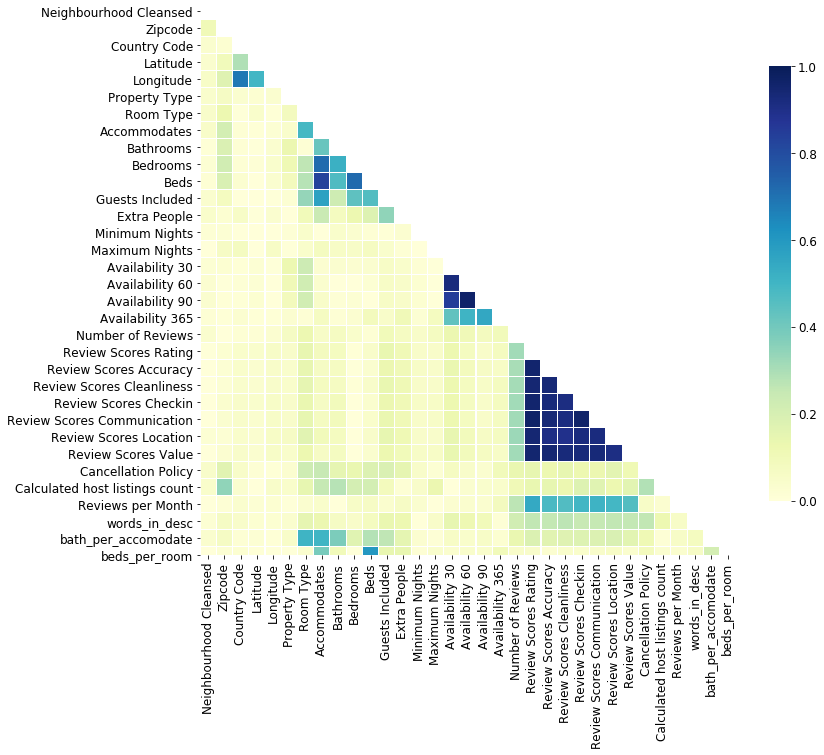

In [27]:
import seaborn as sns

# Calculamos la correlación entre todas las variables (salvo el precio)
corr = np.abs(airbnbtrain_simplified.loc[:,airbnbtrain_simplified.columns != 'Price'].corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Vemos claramente que tenemos información redundante así que hacemos una nueva eliminación de columnas que vemos que no aportan nada:

In [28]:
columns_to_remove_batch2 = [
    'Latitude',
    'Longitude',
    'Accommodates',
    'Beds',
    'Extra People',
    'Availability 60',
    'Availability 90',
    'Availability 365',
    'Review Scores Accuracy',
    'Review Scores Cleanliness',
    'Review Scores Checkin',
    'Review Scores Communication',
    'Review Scores Location',
    'Review Scores Value'
]
remove_df_columns(airbnbtrain_simplified, columns_to_remove_batch2, inplace = True)

**NOTA**: En estos momentos deberíamos aplicar por ejemplo **Lasso** para tratar de eliminar más variables ya que algunas de primeras parece claro que no tendrán relación con el precio final, pero NO se ha realizado en éste ejercicio.

Ahora vamos a echar un vistazo general a todas la variables tal y como están es estos momentos

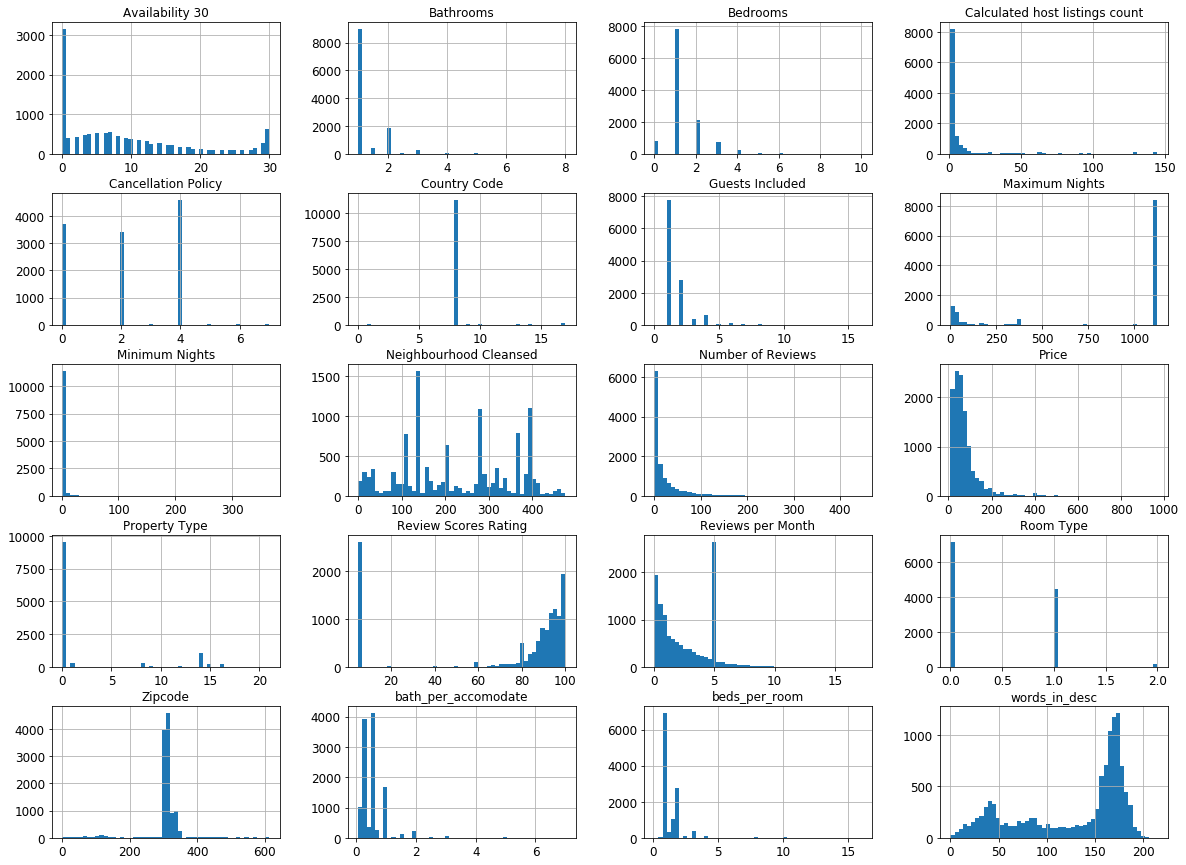

In [29]:
airbnbtrain_simplified.hist(bins=50, figsize=(20,15))
plt.show()

Bien, en estos momentos tenemos varias columas con unos valores muy dispares entre ellas. Sería recomendable por tanto utilizar un **Scaler** para que todos los datos tengan la misma escala y así le sea más facil al modelo predecir la variable tarjet.

In [30]:
from sklearn.preprocessing import StandardScaler

def get_x_y_scaled(dataframe):
    y_train = dataframe['Price']
    x_train = dataframe.drop(columns=['Price'])
    #feature_names = x_train.columns.values
    scaler = StandardScaler().fit(x_train)
    x_train[x_train.columns] = scaler.transform(x_train[x_train.columns])
    return y_train, x_train


In [31]:
y_train, x_trainscaled = get_x_y_scaled(airbnbtrain_simplified)

Ahora vamos a aplicar nuestro modelo mas simple (LinearRegression) a los datos que tenemos para ver los resultados:

In [32]:
from sklearn.linear_model import LinearRegression

# Entrenamos el modelo
lin_reg = LinearRegression()
lin_reg.fit(x_trainscaled, y_train)

# Con los propios datos de train podemos hacernos una idea de lo "bueno" que puede ser el modelo deprimeras
some_data = x_trainscaled.iloc[:5]
some_labels = y_train.iloc[:5]
print("Predicciones:\t", lin_reg.predict(some_data))
print("Valores reales:\t", list(some_labels))

Predicciones:	 [ 90.33193686  80.64916008  19.60938071  92.38481973 106.57263343]
Valores reales:	 [68.0, 50.0, 25.0, 120.0, 90.0]


Con los datos anteriores vemos que el modelo es bastante malo. Los precios no se acercan practicamente al precio real.

Vamos a calcular el **error cuadrático medio** de la predicción para hacernos una idea mejor de su comportamiento.

In [33]:
from sklearn.metrics import mean_squared_error

price_predictions_linreg = lin_reg.predict(x_trainscaled)
lin_mse = mean_squared_error(y_train, price_predictions_linreg)
lin_rmse = np.sqrt(lin_mse)
lin_rmse
# Obtengo 55.10343580010404

55.10343580010404

Como vemos, sin necesidad de introducir los datos de Test vemos que el modelo no va a servir, tiene un error cuadrático medio de 55.10 para precios de por ejemplo 40€, 50€, 80€....

A continuación vamos a utilizar un **RandomForest** de manera similar a lo que utilizamos anteriormente:

In [34]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

ranForesReg = RandomForestRegressor(random_state=33, n_estimators=100, max_depth=10)
ranForesReg.fit(x_trainscaled, y_train)

print("Predicciones:\t", ranForesReg.predict(some_data))
print("Valores reales:\t", list(some_labels))


Predicciones:	 [ 65.52502072  67.62962561  24.67140946  93.88951176 113.86120922]
Valores reales:	 [68.0, 50.0, 25.0, 120.0, 90.0]


De primeras los resultados parecen algo mejores. Vamos a calcular el error cuadrático medio de la predicción sobre el dataframe de Train

In [35]:
from sklearn.metrics import mean_squared_error

price_predictions_ranforest = ranForesReg.predict(x_trainscaled)
rfrst_mse = mean_squared_error(y_train, price_predictions_ranforest)
rfrst_rmse = np.sqrt(rfrst_mse)
print("Error cuadrático medio:", rfrst_rmse)
# Obtengo 31.07297089681125

# Calculamos el score
print("Score Train: ", ranForesReg.score(x_trainscaled, y_train))

Error cuadrático medio: 31.07297089681125
Score Train:  0.8115344360372725


Es claramente mejor que la regresión lineal (pero podría empeorar con los datos de test) pero sigue siendo muy malo. Entre estos dos algoritmos tiene mejor puntuación y menor error cuadrático medio el segundo así que **nos quedamos con el RandomForestRegressor**.

**NOTA**: Normalmente se probarían varios algoritmos, se realizaría crossvalidation, se podría usar "Ensemble" para incluso mezclar lo mejor de cada modelo, pero por tiempo no se realizará en esta práctrica

Ahora dado que casi tenemos claro que modelo utilizar, vamos a ver el score y el error cuadrático medio sobre los datos de **Test**.

Debemos realizar las transformaciones que hemos realizado en train también en test:

In [36]:
def transformDataFrame(df):
    fill_accomodates_row(df)
    fill_beds_row(df)
    fill_bedrooms_row(df)
    generate_new_columns(df)
    remove_df_columns(df, columns_to_remove, inplace = True)
    transform_cols(df)
    fill_nas(df)
    df['Maximum Nights'] = df['Maximum Nights'].apply(lambda x: x if x < 1125 else 1125 )
    remove_df_columns(df, columns_to_remove_batch2, inplace = True)
    
test = airbnb_test.copy()
# Hacemos todas las transformaciones
transformDataFrame(test)
# Escalamos también el test
y_test, x_testscaled = get_x_y_scaled(test.dropna(how='any'))
print("Score test: ", ranForesReg.score(x_testscaled, y_test))
# Score test:  0.5793535214962777

Score test:  0.5793535214962777


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


El resultado es bastante malo. Los resultados es que la predicción es como ya estavamos aventurando: mala. Deberíamos entrenar el modelo con más datos para obtener mejores resultados, y tratar las variables con más tiempo. 
